http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

http://www.ipeadata.gov.br/

https://dadosdadosdados.wordpress.com/2015/09/25/trabalhando-com-series-temporais-no-r-parte-i-2/

In [135]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

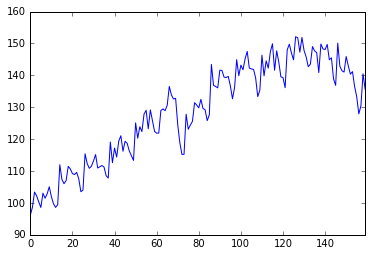

In [3]:
dataset = pandas.read_csv('ibc_br_20160918.csv', usecols=[0,1], engine='python')
dataset.columns = ['DATA','IBC_BR']
dataset['IBC_BR'].plot()

In [4]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score

Using Theano backend.


In [5]:
# fix random seed for reproducibility
numpy.random.seed(42)

In [71]:
# load the dataset
#dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataframe = pandas.read_csv('ibc_br_20160918.csv', usecols=[0,1], engine='python')
dataframe.columns = ['DATA','IBC_BR']
#dataset = dataframe['IBC_BR'].values.reshape(-1, 1)
#dataset = dataset.astype('float32')

### Add trend and seasonal factor

In [76]:
seasonal = pd.get_dummies(dataframe['DATA'].apply(lambda x: int(str(x).split('.')[-1])))
seasonal.columns = ['D'+str(x) for x in range(1,12)]

In [77]:
data = pd.concat([dataframe, seasonal], axis=1)
data['TREND'] = range(0, dataframe.shape[0])

In [85]:
data['LAG_IBC_BR'] = data.groupby(['DATA'])['IBC_BR'].mean().shift(1).reset_index(drop=True)

In [92]:
data = data.rename(columns={'IBC_BR':'TARGET'})

In [103]:
data = data.fillna(0)

In [87]:
del data['DATA']

In [104]:
# convert an array of values into a dataset matrix
def create_dataset(df):
    dataX, dataY = [], []
    dataY = df['TARGET']
    dataX = df.ix[:, df.columns != 'TARGET']
    
    
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataX = scaler.fit_transform(dataX)
        
    return numpy.array(dataX), numpy.array(dataY)

In [115]:
# split into train and test sets
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data.loc[0:train_size,:], data.loc[train_size:len(data),:]
print(len(train), len(test))

(108, 53)


In [117]:
# reshape into X=t and Y=t+1
trainX, trainY = create_dataset(data)
testX, testY = create_dataset(test)

In [118]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [119]:
import numpy as np
from keras import backend as K
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis=-1)

def rsquared(y_true, y_pred):
    ssres = K.mean(K.square(y_true - y_pred), axis=-1)
    sstot = K.square(y_true -K.mean(y_true))
    rsquare = (1 - (ssres/sstot))
    return rsquare

def sum_squared_error(y_true, y_pred):
    return K.sum(K.square(y_true - y_pred), axis=-1)

In [131]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=(data.shape[1]-1)))
model.add(Dropout(0.2))
model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='adam')
hist = model.fit(trainX, trainY, nb_epoch=1000, batch_size=1, verbose=2, validation_split=0.3)

Train on 112 samples, validate on 48 samples
Epoch 1/1000
0s - loss: 15017.5976 - val_loss: 20639.3310
Epoch 2/1000
0s - loss: 14959.1755 - val_loss: 20547.9289
Epoch 3/1000
0s - loss: 14879.4948 - val_loss: 20413.5729
Epoch 4/1000
0s - loss: 14769.5635 - val_loss: 20234.1868
Epoch 5/1000
0s - loss: 14608.5425 - val_loss: 20003.1141
Epoch 6/1000
0s - loss: 14452.8565 - val_loss: 19765.4803
Epoch 7/1000
0s - loss: 14266.7156 - val_loss: 19555.2115
Epoch 8/1000
0s - loss: 14072.2592 - val_loss: 19376.9861
Epoch 9/1000
0s - loss: 13910.2551 - val_loss: 19224.5914
Epoch 10/1000
0s - loss: 13732.5004 - val_loss: 19079.7725
Epoch 11/1000
0s - loss: 13649.4041 - val_loss: 18945.2569
Epoch 12/1000
0s - loss: 13539.1498 - val_loss: 18814.7673
Epoch 13/1000
0s - loss: 13412.8078 - val_loss: 18687.7492
Epoch 14/1000
0s - loss: 13282.4914 - val_loss: 18563.5347
Epoch 15/1000
0s - loss: 13167.5954 - val_loss: 18439.2392
Epoch 16/1000
0s - loss: 13075.6829 - val_loss: 18319.5636
Epoch 17/1000
0s - l

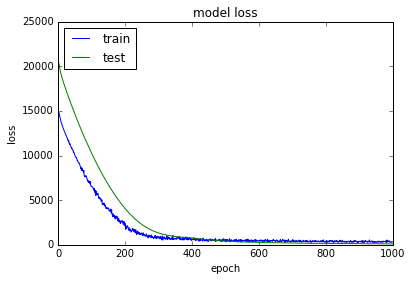

In [132]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
trainScore = math.sqrt(trainScore)
trainScore = scaler.inverse_transform(numpy.array([[trainScore]]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = model.evaluate(testX, testY, verbose=0)
testScore = math.sqrt(testScore)
testScore = scaler.inverse_transform(numpy.array([[testScore]]))
print('Test Score: %.2f RMSE' % (testScore))

In [138]:
print r2_score(trainY,model.predict(trainX)), r2_score(testY,model.predict(testX))

0.740744231199 -20.7133945032


In [141]:
print len(testPredict),len(data)

53 160


In [137]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
 
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(data)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[0:len(trainPredict), :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(data)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict):len(data), :] = testPredict

ValueError: could not broadcast input array from shape (53,1) into shape (0,14)

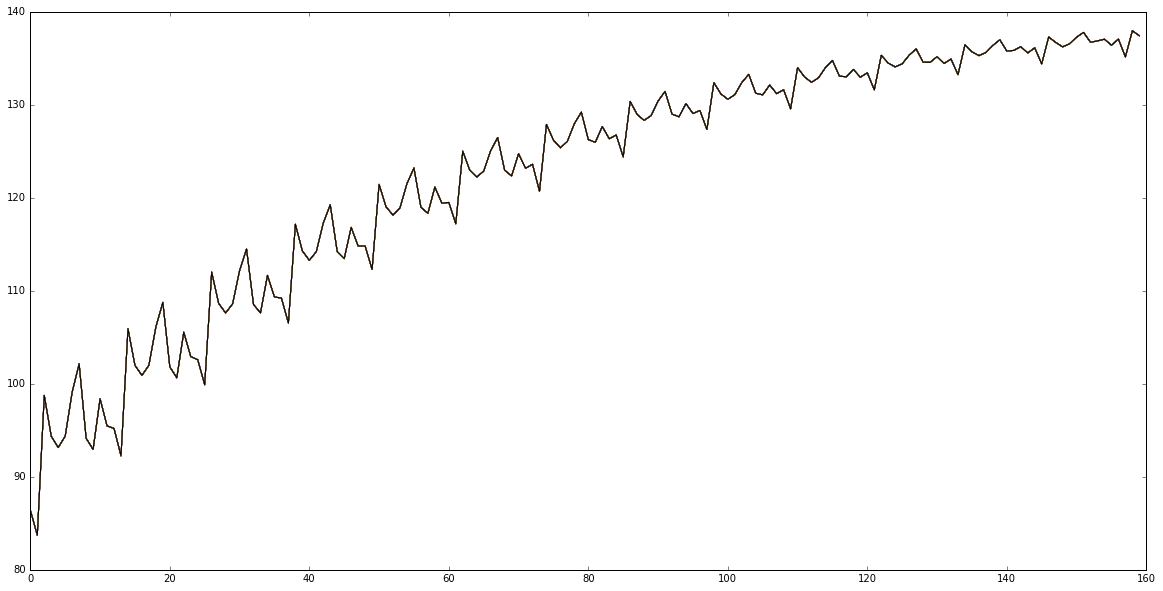

In [144]:
# plot baseline and predictions
plt.figure(figsize=(20,10))
#plt.plot(data)
plt.plot(trainPredictPlot)
#plt.plot(testPredictPlot)

### Multi-layer perceptron

In [ ]:
# Multilayer Perceptron to Predict International Airline Passengers (t+1, given t)
import numpy
import matplotlib.pyplot as plt
import pandas
from keras.models import Sequential
from keras.layers import Dense
 
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
 
# fix random seed for reproducibility
numpy.random.seed(7)
 
# load the dataset
#dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
#dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataframe = pandas.read_csv('ibc_br_20160918.csv', usecols=[0,1], engine='python')
dataframe.columns = ['DATA','IBC_BR']
dataset = dataframe['IBC_BR'].values.reshape(-1, 1)
#dataset = dataframe.values
dataset = dataset.astype('float32')
 
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,], dataset[train_size:len(dataset),]
print(len(train), len(test))
 
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
 
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=200, batch_size=2, verbose=2)
 
# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: ', trainScore)
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: ', testScore)
 
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
 
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
 
# plot baseline and predictions


In [ ]:
print r2_score(trainY,model.predict(trainX)), r2_score(testY,model.predict(testX))

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)